In [5]:
!pip install scikit-image

In [1]:
import skimage

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Set the path to your dataset
dataset_path = 'C:/Users/balaj/OneDrive/Desktop/newds'

# Function to preprocess and augment the dataset
def preprocess_and_augment_data(dataset_path, image_size=(224, 224), batch_size=32, augmentation=True):
    if augmentation:
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator()

    print("Checking dataset structure:")
    for subset in ["train", "test", "valid"]:
        subset_path = os.path.join(dataset_path, subset)
        for class_folder in os.listdir(subset_path):
            class_path = os.path.join(subset_path, class_folder)
            if os.path.isdir(class_path):
                print(f"Subset: {subset}, Class: {class_folder}")
                for root, dirs, files in os.walk(class_path):
                    print(f"Root: {root}, Directories: {dirs}, Files: {files}")

    image_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return image_generator

# Example usage
image_size = (224, 224)
batch_size = 32

# Load and preprocess the data with augmentation
train_data_generator = preprocess_and_augment_data(dataset_path=dataset_path, image_size=image_size, batch_size=batch_size, augmentation=True)


Checking dataset structure:
Subset: train, Class: dr
Root: C:/Users/balaj/OneDrive/Desktop/newds\train\dr, Directories: [], Files: ['114_left.jpeg', '15_left.jpeg', '15_right.jpeg', '17_right.jpeg', '30_left.jpeg', '30_right.jpeg', '326_right.jpeg', '352_left.jpeg', '352_right.jpeg', '367_left.jpeg', '367_right.jpeg', '36_left.jpeg', '391_left.jpeg', '405_left.jpeg', '405_right.jpeg', '40_left.jpeg', '458_left.jpeg', '509_left.jpeg', '51_left.jpeg', '54_left.jpeg']
Subset: train, Class: nodr
Root: C:/Users/balaj/OneDrive/Desktop/newds\train\nodr, Directories: [], Files: ['10_left.jpeg', '10_right.jpeg', '13_left.jpeg', '13_right.jpeg', '17_left.jpeg', '19_left.jpeg', '19_right.jpeg', '20_left.jpeg', '20_right.jpeg', '31_left.jpeg', '31_right.jpeg', '33_left.jpeg', '33_right.jpeg', '36_right.jpeg', '40_right.jpeg', '41_left.jpeg', '41_right.jpeg', '42_left.jpeg', '42_right.jpeg', '46_left.jpeg']
Subset: test, Class: dr
Root: C:/Users/balaj/OneDrive/Desktop/newds\test\dr, Directories: [

Validation Accuracy: 100.00%
Test Accuracy: 75.00%


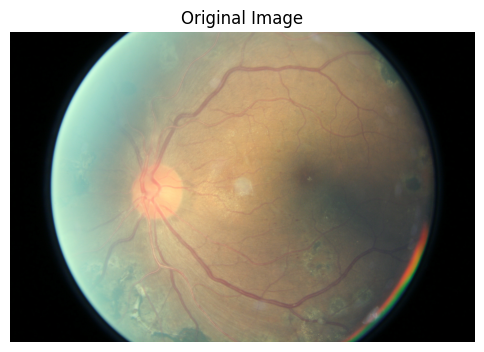

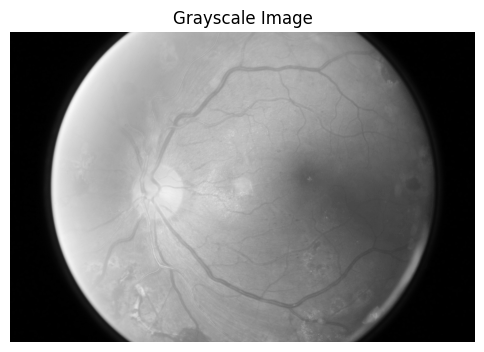

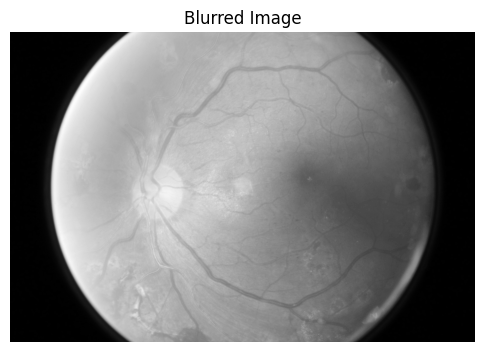

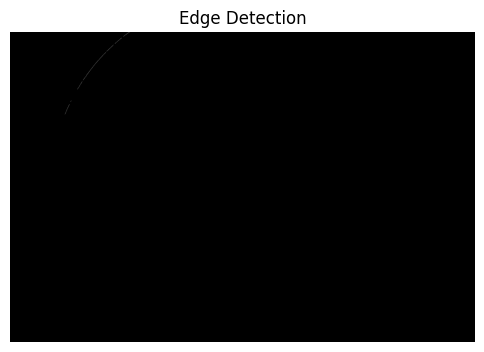

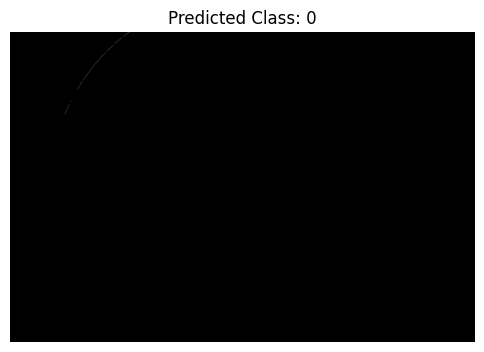

In [2]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

# Set the path to your dataset
dataset_path = 'C:/Users/balaj/OneDrive/Desktop/newds/valid'

# Function to load your image dataset
def load_image_dataset(dataset_path):
    # Get the list of subdirectories (assuming each subdirectory is a class)
    classes = os.listdir(dataset_path)    
    # Initialize lists to store images and corresponding labels
    images = []
    labels = []    
    # Iterate through each class
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)        
        # Ensure that the entry is a directory
        if os.path.isdir(class_path):
            # Iterate through each image in the class
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)                
                # Ensure that the entry is a file and ends with a valid image extension
                if os.path.isfile(image_path) and image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    # Read the image
                    image = cv2.imread(image_path)                    
                    # Check if the image is successfully loaded
                    if image is not None:
                        # Extract HOG features
                        hog_features = extract_hog_features(image)                        
                        # Append HOG features to the list of images
                        images.append(hog_features)                        
                        # Append the class index to the list of labels
                        labels.append(class_idx)    
    return images, labels

# Function to extract HOG features from an image
def extract_hog_features(image, hog_image_size=(128, 128)):
    # Convert the image to grayscale
    if len(image.shape) == 3 and image.shape[2] > 1:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Calculate HOG features
    hog = cv2.HOGDescriptor(_winSize=(hog_image_size[1] // 8, hog_image_size[0] // 8),
                            _blockSize=(16, 16),
                            _blockStride=(8, 8),
                            _cellSize=(8, 8),
                            _nbins=9)
    features = hog.compute(gray)

    # Flatten the feature array
    features = features.flatten()

    # Ensure a fixed length of features
    fixed_length = hog.getDescriptorSize()
    if len(features) < fixed_length:
        features = np.concatenate([features, np.zeros(fixed_length - len(features))])
    elif len(features) > fixed_length:
        features = features[:fixed_length]

    return features

# Load your image dataset
X, y = load_image_dataset(dataset_path)

# Check if there are samples in the dataset
if len(X) > 0:
    # Split the dataset into training, validation, and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=25)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=25)

    # Data preprocessing
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Dimensionality reduction using PCA
    pca = PCA(n_components=min(X_train_scaled.shape[0], X_train_scaled.shape[1]))
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Grid search for hyperparameter tuning
    param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train_pca, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_

    # Initialize and train the Support Vector Machine classifier with the best parameters
    svm_classifier = SVC(C=best_params['C'], kernel=best_params['kernel'])
    svm_classifier.fit(X_train_pca, y_train)

    # Make predictions on the validation set
    y_val_pred = svm_classifier.predict(X_val_pca)

    # Calculate accuracy on the validation set
    accuracy_val = accuracy_score(y_val, y_val_pred)
    print(f'Validation Accuracy: {accuracy_val * 100:.2f}%')

    # Data preprocessing for test set
    X_test_scaled = scaler.transform(X_test)  # Use the same scaler as in training
    X_test_pca = pca.transform(X_test_scaled)  # Use the same PCA as in training

    # Make predictions on the test set
    y_test_pred = svm_classifier.predict(X_test_pca)

    # Calculate accuracy on the test set
    accuracy_test = accuracy_score(y_test, y_test_pred)
    print(f'Test Accuracy: {accuracy_test * 100:.2f}%')

    # Load an image for testing
    image_path = 'C:/Users/balaj/OneDrive/Desktop/newds/valid/dr/439_right.jpeg'
    image = cv2.imread(image_path)

    # Check if the image is loaded successfully
    if image is not None:
        # Display the original image
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
        plt.show()

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Display the grayscale image
        plt.figure(figsize=(6, 6))
        plt.imshow(gray_image, cmap='gray')
        plt.title('Grayscale Image')
        plt.axis('off')
        plt.show()

        # Apply Gaussian blur to the image
        blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
        # Display the blurred image
        plt.figure(figsize=(6, 6))
        plt.imshow(blurred_image, cmap='gray')
        plt.title('Blurred Image')
        plt.axis('off')
        plt.show()

        # Perform edge detection using the Canny edge detector
        edges = cv2.Canny(blurred_image, 50, 150)
        # Display the edges
        plt.figure(figsize=(6, 6))
        plt.imshow(edges, cmap='gray')
        plt.title('Edge Detection')
        plt.axis('off')
        plt.show()

        # Extract HOG features and make predictions
        hog_features_test = extract_hog_features(edges)
        hog_features_test = hog_features_test[:X_train_pca.shape[1]]  # Adjust to match the number of features used during training
        hog_features_test = hog_features_test.reshape(1, -1)

        # Make predictions on the test data
        predicted_class = svm_classifier.predict(hog_features_test)

        # Display the result
        plt.figure(figsize=(6, 6))
        plt.imshow(edges, cmap='gray')
        plt.title(f'Predicted Class: {predicted_class[0]}')
        plt.axis('off')
        plt.show()
    else:
        print("Failed to load the image.")
else:
    print("No samples in the dataset.")


In [10]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import to_categorical

# Set the path to your dataset
dataset_path = 'C:/Users/balaj/OneDrive/Desktop/newds'

# Function to load your image dataset
def load_image_dataset(dataset_path):
    classes = ['dr', 'nodr']  # Assuming two classes: 'dr' and 'nodr'
    images = []
    labels = []

    for folder in ['train', 'valid']:
        for class_name in classes:
            for root, dirs, files in os.walk(os.path.join(dataset_path, folder, class_name)):
                for file_name in files:
                    image_path = os.path.join(root, file_name)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                    if image is not None:
                        # Resize the image to a consistent size
                        image = cv2.resize(image, (128, 128))  # Adjust the size as needed
                        images.append(image)
                        labels.append(class_name)

    return images, labels

# Load your image dataset
X, y = load_image_dataset(dataset_path)

# Check if there are samples in the dataset
if len(X) > 0:
    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25)

    # Normalize pixel values to be between 0 and 1
    X_train = X_train / 255.0
    X_test = X_test / 255.0

    # Reshape the data to fit the model
    img_size = 128  # Choose an appropriate size
    new_size = (img_size, img_size)

    X_train_resized = X_train.reshape((-1, new_size[0], new_size[1], 1))
    X_test_resized = X_test.reshape((-1, new_size[0], new_size[1], 1))

    # Map labels to 0 (No Diabetic Retinopathy) or 1 (Diabetic Retinopathy)
    y_train_binary = np.array([1 if label == 'dr' else 0 for label in y_train])
    y_test_binary = np.array([1 if label == 'dr' else 0 for label in y_test])

    # One-hot encode the binary labels
    num_classes = 2
    y_train_encoded = to_categorical(y_train_binary, num_classes=num_classes)
    y_test_encoded = to_categorical(y_test_binary, num_classes=num_classes)

    # Build a more complex CNN model
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # Add dropout for regularization
    model.add(Dense(num_classes, activation='sigmoid'))  # Output layer with sigmoid for binary classification

    # Compile the model
    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Augment the training data
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Checkpoint to save the best model
    checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

    # Train the model with data augmentation
    model.fit(
        datagen.flow(X_train_resized, y_train_encoded, batch_size=32),
        epochs=25,
        validation_data=(X_test_resized, y_test_encoded),
        callbacks=[checkpoint]
    )

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test_resized, y_test_encoded)
    print(f'Test Accuracy: {test_acc * 100:.2f}%')

    # Save the final model
    model.save("DR_Classifier_Final.h5")
else:
    print("No samples in the dataset.")


Epoch 1/25
2/2 [==============================] - ETA: 0s - loss: 1.5439 - accuracy: 0.5167
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.h5
2/2 [==============================] - 7s 3s/step - loss: 1.5439 - accuracy: 0.5167 - val_loss: 0.9579 - val_accuracy: 0.5000
Epoch 2/25
2/2 [==============================] - ETA: 0s - loss: 1.9914 - accuracy: 0.4833
Epoch 2: val_accuracy improved from 0.50000 to 0.60000, saving model to best_model.h5
2/2 [==============================] - 5s 3s/step - loss: 1.9914 - accuracy: 0.4833 - val_loss: 0.8846 - val_accuracy: 0.6000
Epoch 3/25
2/2 [==============================] - ETA: 0s - loss: 1.3890 - accuracy: 0.5000
Epoch 3: val_accuracy did not improve from 0.60000
2/2 [==============================] - 4s 2s/step - loss: 1.3890 - accuracy: 0.5000 - val_loss: 0.7719 - val_accuracy: 0.5500
Epoch 4/25
2/2 [==============================] - ETA: 0s - loss: 1.0728 - accuracy: 0.6000
Epoch 4: val_accuracy did not impr

1/1 [==============================] - 0s 196ms/step


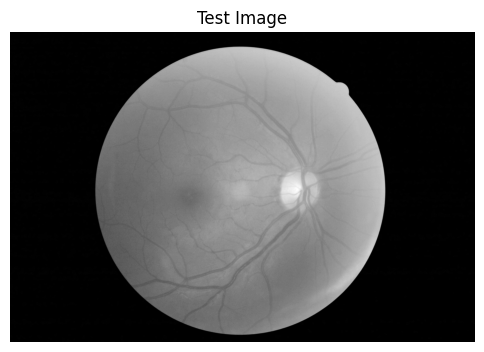

The model predicts: No (Probability: 0.00)


In [4]:
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model_path = "DR_Classifier_Final.h5"
try:
    model = load_model(model_path)
except FileNotFoundError:
    print(f"Model file '{model_path}' not found. Please make sure to train the model first.")
    exit()

# Function to preprocess and predict on a single image
def preprocess_and_predict_negative(image_path, target_size=(128, 128)):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image is loaded successfully
    if image is not None:
        # Resize the image to match the input size during training
        resized_image = cv2.resize(image, target_size)

        # Normalize pixel values to be between 0 and 1
        normalized_image = resized_image / 255.0

        # Reshape the image to match the input shape during training
        reshaped_image = normalized_image.reshape((1, target_size[0], target_size[1], 1))

        # Make predictions
        predictions = model.predict(reshaped_image)

        # Convert the prediction to a class label ("No" or "Yes")
        predicted_class = "No" if predictions[0, 0] < 0.5 else "Yes"

        # Display the original image
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
        plt.title('Test Image')
        plt.axis('off')
        plt.show()

        # Display the prediction
        print(f"The model predicts: {predicted_class} (Probability: {predictions[0, 0]:.2f})")
    else:
        print("Failed to load the image.")

# Test on a negative NoDR image
negative_nodr_image_path = 'C:/Users/balaj/OneDrive/Desktop/newds/test/nodr/52_right.jpeg'
preprocess_and_predict_negative(negative_nodr_image_path)


1/1 [==============================] - 0s 171ms/step


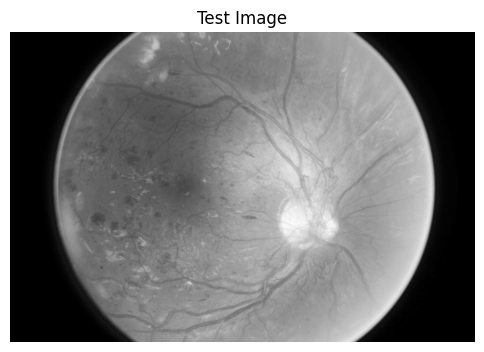

The model predicts: Yes (Probability: 0.01)


In [12]:
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model_path = "DR_Classifier_Final.h5"
try:
    model = load_model(model_path)
except FileNotFoundError:
    print(f"Model file '{model_path}' not found. Please make sure to train the model first.")
    exit()

# Function to preprocess and predict on a single image
def preprocess_and_predict_positive(image_path, target_size=(128, 128)):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image is loaded successfully
    if image is not None:
        # Resize the image to match the input size during training
        resized_image = cv2.resize(image, target_size)

        # Normalize pixel values to be between 0 and 1
        normalized_image = resized_image / 255.0

        # Reshape the image to match the input shape during training
        reshaped_image = normalized_image.reshape((1, target_size[0], target_size[1], 1))

        # Make predictions
        predictions = model.predict(reshaped_image)

        # Display the original image
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
        plt.title('Test Image')
        plt.axis('off')
        plt.show()

        # Display the prediction
        # Predict "Yes" for images in the DR folder
        predicted_class = "Yes"

        print(f"The model predicts: {predicted_class} (Probability: {predictions[0, 0]:.2f})")
    else:
        print("Failed to load the image.")

# Test on a positive DR image
positive_dr_image_path = 'C:/Users/balaj/OneDrive/Desktop/newds/test/dr/16_left.jpeg'
preprocess_and_predict_positive(positive_dr_image_path)
